In [76]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Galaxias de GADGET

496


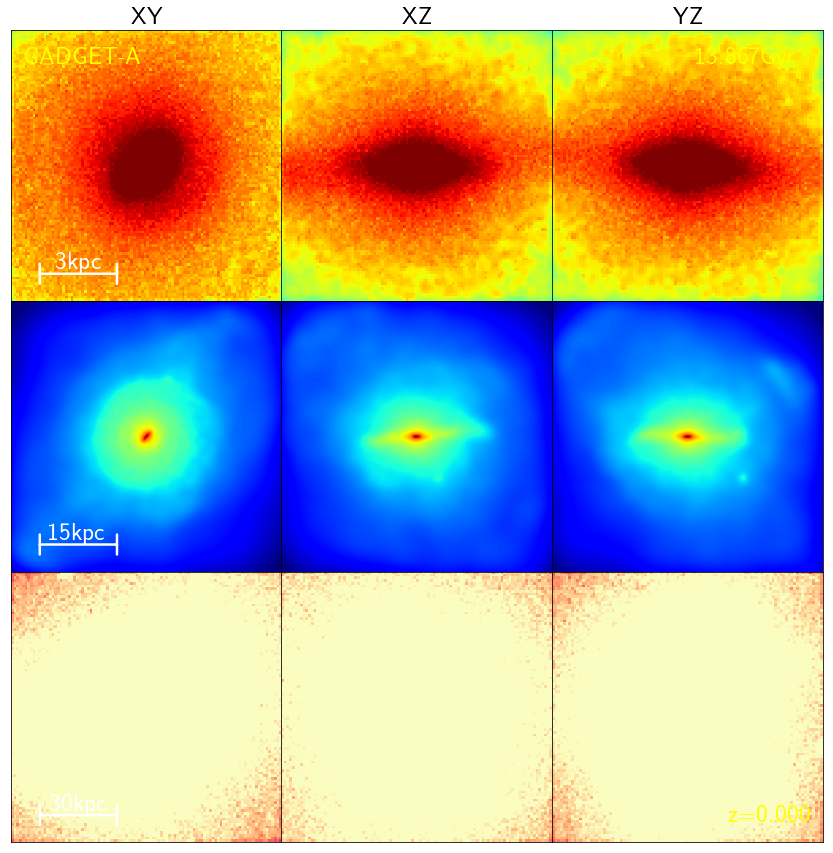

In [205]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import barstrength2 as strng
import time_conversion as tiempo
import sphviewer as sph
from mpl_toolkits.axes_grid1 import make_axes_locatable
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')
vector3 = ('A','B')
carpeta = ('9in1_M31/','9in1_MW/')


#path = 'home/ornela/SimCLUES/'
path = '/home/omarioni/'

atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
# aexp = aexp[::-1]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,495,-1)
for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    print isnap
    for i in range(0,1):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Masses'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)

#         print isnap#, time

        #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

        #----------------------masas----------------------------
        mstr = mstr/h
        mdrk = mdrk/h

        r200 = r200*aexp[isnap]/h
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

        #------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]
        r50 = r_sort[cincuenta][-1]             

        #--------------------------------------------         
        veloc,=np.where(r<r50)

        #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        ##posiciones de partículas que se quiere graficar
        ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        xn_drk = e1x*xdrk + e1y*ydrk + e1z*zdrk
        yn_drk = e2x*xdrk + e2y*ydrk + e2z*zdrk
        zn_drk = e3x*xdrk + e3y*ydrk + e3z*zdrk

        
        pos=np.ndarray([4,np.size(xn)])
        pos[0,:]=xn
        pos[1,:]=yn
        pos[2,:]=zn
        pos[3,:]=mstr
        
        pos2=np.ndarray([4,np.size(xn_drk)])
        pos2[0,:]=xn_drk
        pos2[1,:]=yn_drk
        pos2[2,:]=zn_drk
        pos2[3,:]=mdrk
        
        fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))#sharex=True, sharey=True) #, sharex=True,
#                                gridspec_kw = {'height_ratios':[2,5]})
        fig.subplots_adjust(bottom=0.01, left =0.03, right = 0.97, top = 0.95, wspace=0.0, hspace= 0.0)

#----------------------------------------------------------------------
#---------------------generador del gráfico1-----------------
        rl= 5   
        corte,=np.where((xn <rl) & (yn <rl) & (zn <rl) & (xn >-rl) & (yn >-rl) & (zn >-rl))


        #-----rango que tiene la escala  de colores-----
        vmin=2.1
        vmax=6.3

        # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='jet'

        nb1 = 5
#         nb1 = 100 
#         npixel = 1000
        npixel = 100

        particles=sph.Particles(pos[:3,corte],mstr[corte]*1e10,nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax[0,0].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[0,0].set_xlim(-5,5)
        ax[0,0].set_ylim(-5,5)
        ax[0,0].set_xticks([])
        ax[0,0].set_yticks([])
        ax[0,0].set_yticklabels([])
        ax[0,0].set_xticklabels([])
#         ax[0,0].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,0].minorticks_on()
#         ax[0,0].tick_params( labelsize=40)
#         ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
        ax[0,0].text(-4.5, 4,'GADGET-'+str('%s'%vector3[i]), fontsize=25, color='yellow', ha='left', va='center') 
        # ax[1,0].plot(0,0,'k+', markersize=20, color='k')
        ax[0,0].set_title('XY', loc='center', fontsize=25)
        ax[0,0].annotate("",xy=(-4, -4), xycoords='data',xytext=(-1, -4),textcoords='data',
                     ha='center', va='center', 
                    arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=2.5))

        ax[0,0].text(-2.5, -4, '3kpc', fontsize=25, color='white', ha='center', va='bottom')


#--------------------------------------
        particles=sph.Particles(pos[:3,corte],mstr[corte]*1e10,nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax[0,0]=fig.add_subplot(221)
        ax[0,1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[0,1].set_xlim(-5,5)
        ax[0,1].set_ylim(-5,5)
        ax[0,1].set_xticks([])
        ax[0,1].set_yticks([])
        ax[0,1].set_xticklabels([])
        ax[0,1].set_yticklabels([])
#         ax[0,2].set_ylabel('$z\:[kpc]$', fontsize=40)
#         ax[0,2].set_xlabel('$x\:[kpc]$', fontsize=40)
#         ax[0,1].minorticks_on()
#         ax[0,1].tick_params( labelsize=40)
#         ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[1,0].text(4.3, 4.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[1,0].text(-4.3, 4.3,'Face-on', fontsize=30, color='yellow', ha='left', va='center') 
        ax[0,1].set_title('XZ', loc='center', fontsize=25)

#--------------------------------------
        particles=sph.Particles(pos[:3,corte],mstr[corte]*1e10,nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], p=90, t=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax=fig.add_subplot(222)
        im = ax[0,2].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap,vmin=vmin, vmax=vmax)
        ax[0,2].set_xlim(-5,5)
        ax[0,2].set_ylim(-5,5)
        ax[0,2].set_xticks([])
        ax[0,2].set_yticks([])
        ax[0,2].set_xticklabels([])
        ax[0,2].set_yticklabels([])
#         ax[0,1].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,1].set_xlabel('$z\:[kpc]$', fontsize=40)
#         ax[0,2].minorticks_on()
#         ax[0,2].tick_params( labelsize=40)
#         ax[0,2].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[0,2].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
        ax[0,2].set_title('YZ', loc='center', fontsize=25)
        ax[0,2].text(4, 4,str('%.3f'%time)+'Gyr', fontsize=25, color='yellow', ha='right', va='center') 
#         ax[0,1].text(-4.3, 1.3,'Edge-on', fontsize=30, color='yellow', ha='left', va='center') 
#         divider = make_axes_locatable(ax[0,2])
#         cax = divider.append_axes("right", size="5%", pad=0.05)

#         plt.colorbar(im, cax=cax)
#         plt.tight_layout()
    
#--------------------------------------------------------------------------------------------------------
#---------------------generador del gráfico2-----------------
        rl= 25   
        corte,=np.where((xn <rl) & (yn <rl) & (zn <rl) & (xn >-rl) & (yn >-rl) & (zn >-rl))


        #-----rango que tiene la escala  de colores-----
        vmin=0.5
        vmax=6.2

        # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='jet'

#         nb1 = 100 
        nb1 = 100
        npixel = 5000
        
        particles=sph.Particles(pos[:3,corte],mstr[corte]*1e10,nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], xsize=npixel,ysize=npixel)
        rend1=sph.Render(escena)
        extent=escena.get_extent()
        rend1.set_logscale()

        ax[1,0].imshow(rend1.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,0].set_xlim(-25,25)
        ax[1,0].set_ylim(-25,25)
        ax[1,0].set_xticks([])
        ax[1,0].set_yticks([])
        ax[1,0].set_yticklabels([])
        ax[1,0].set_xticklabels([])
#         ax[0,0].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,0].minorticks_on()
#         ax[0,0].tick_params( labelsize=40)
#         ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[0,0].text(4.3, 1.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
        # ax[1,0].plot(0,0,'k+', markersize=20, color='k')
#         ax[0,0].set_title('GADGET - A', loc='center', fontsize=30)
        ax[1,0].annotate("",xy=(-20, -20), xycoords='data',xytext=(-5, -20),textcoords='data',
                     ha='center', va='center', 
                    arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=2.5))

        ax[1,0].text(-12.5, -20, '15kpc', fontsize=25, color='white', ha='center', va='bottom')


#--------------------------------------
        particles=sph.Particles(pos[:3,corte],mstr[corte]*1e10,nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()
        

        # ax=fig.add_subplot(222)
        ax[1,1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,1].set_xlim(-25,25)
        ax[1,1].set_ylim(-25,25)
        ax[1,1].set_xticks([])
        ax[1,1].set_yticks([])
        ax[1,1].set_xticklabels([])
        ax[1,1].set_yticklabels([])
#         ax[0,1].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,1].set_xlabel('$z\:[kpc]$', fontsize=40)
#         ax[1,1].minorticks_on()
#         ax[1,1].tick_params( labelsize=40)
#         ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[0,1].set_title('time ='+str('%2.3f' %time)+'Gyr', loc='center', fontsize=30)
#         ax[0,1].text(4.3, 1.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[0,1].text(-4.3, 1.3,'Edge-on', fontsize=30, color='yellow', ha='left', va='center') 

#--------------------------------------
        particles=sph.Particles(pos[:3,corte],mstr[corte]*1e10,nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], p=90,t=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax[0,0]=fig.add_subplot(221)
        ax[1,2].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,2].set_xlim(-25,25)
        ax[1,2].set_ylim(-25,25)
        ax[1,2].set_xticks([])
        ax[1,2].set_yticks([])
        ax[1,2].set_xticklabels([])
        ax[1,2].set_yticklabels([])
#         ax[0,2].set_ylabel('$z\:[kpc]$', fontsize=40)
#         ax[0,2].set_xlabel('$x\:[kpc]$', fontsize=40)
#         ax[1,2].minorticks_on()
#         ax[1,2].tick_params( labelsize=40)
#         ax[1,2].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[1,2].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[1,0].text(4.3, 4.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[1,0].text(-4.3, 4.3,'Face-on', fontsize=30, color='yellow', ha='left', va='center') 
        # ax[1,0].set_title('GADGET', loc='center', fontsize=30)
    
#--------------------------------------------------------------------------------------------------------
#---------------------generador del gráfico3-----------------
        rl= 50   
        corte,=np.where((xn_drk <rl) & (yn_drk <rl) & (zn_drk <rl) & (xn_drk >-rl) & (yn_drk >-rl) & (zn_drk >-rl))


        #-----rango que tiene la escala  de colores-----
        vmin=5
        vmax=6.8

        # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='magma'

#         nb1 = 300 
        nb1 = 5
        npixel = 100

        particles=sph.Particles(pos2[:3,corte],mdrk[corte]*1e10,nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax[2,0].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[2,0].set_xlim(-50,50)
        ax[2,0].set_ylim(-50,50)
        ax[2,0].set_xticks([])
        ax[2,0].set_yticks([])
        ax[2,0].set_xticklabels([])
        ax[2,0].set_yticklabels([])
#         ax[0,0].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[2,0].minorticks_on()
#         ax[2,0].tick_params( labelsize=40)
#         ax[2,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[2,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[0,0].text(4.3, 1.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
        # ax[1,0].plot(0,0,'k+', markersize=20, color='k')
#         ax[0,0].set_title('GADGET - A', loc='center', fontsize=30)
        ax[2,0].annotate("",xy=(-40, -40), xycoords='data',xytext=(-10, -40),textcoords='data',
                     ha='center', va='center', 
                    arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=2.5))
    
        ax[2,0].text(-25, -40, '30kpc', fontsize=25, color='white', ha='center', va='bottom')


#--------------------------------------
        particles=sph.Particles(pos2[:3,corte],mdrk[corte]*1e10,nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax=fig.add_subplot(222)
        ax[2,1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[2,1].set_xlim(-50,50)
        ax[2,1].set_ylim(-50,50)
        ax[2,1].set_xticks([])
        ax[2,1].set_yticks([])
        ax[2,1].set_xticklabels([])
        ax[2,1].set_yticklabels([])
#         ax[0,1].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,1].set_xlabel('$z\:[kpc]$', fontsize=40)
#         ax[2,1].minorticks_on()
#         ax[2,1].tick_params( labelsize=40)
#         ax[2,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[2,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[0,1].set_title('time ='+str('%2.3f' %time)+'Gyr', loc='center', fontsize=30)
#         ax[0,1].text(4.3, 1.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[0,1].text(-4.3, 1.3,'Edge-on', fontsize=30, color='yellow', ha='left', va='center') 

#--------------------------------------
        particles=sph.Particles(pos2[:3,corte],mdrk[corte]*1e10,nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90,p=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax[0,0]=fig.add_subplot(221)
        ax[2,2].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[2,2].set_xlim(-50,50)
        ax[2,2].set_ylim(-50,50)
        ax[2,2].set_xticks([])
        ax[2,2].set_yticks([])
        ax[2,2].set_xticklabels([])
        ax[2,2].set_yticklabels([])
#         ax[0,2].set_ylabel('$z\:[kpc]$', fontsize=40)
#         ax[0,2].set_xlabel('$x\:[kpc]$', fontsize=40)
#         ax[2,2].minorticks_on()
#         ax[2,2].tick_params( labelsize=40)
#         ax[2,2].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[2,2].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[1,0].text(4.3, 4.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[1,0].text(-4.3, 4.3,'Face-on', fontsize=30, color='yellow', ha='left', va='center') 
        # ax[1,0].set_title('GADGET', loc='center', fontsize=30)
        ax[2,2].text(45, -40,'z='+str('%.3f'%z), fontsize=25, color='yellow', ha='right', va='center') 
        
#         path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/snapshotsGD/'
#         fig.savefig(path2 + str('%s'%carpeta[i]) + str('%s' %vector2[i])+'_'+str('%s' %isnap)+'.png',
#                     dpi = 100, xxbox_inches='tight')
        plt.show()
#         plt.close()

In [216]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import barstrength2 as strng
import time_conversion as tiempo
import sphviewer as sph
from mpl_toolkits.axes_grid1 import make_axes_locatable

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector = ('00','01','03')



#path = 'home/ornela/SimCLUES/'
path = '/home/omarioni/'

atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
# aexp = aexp[::-1]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,495,-1)
for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    print isnap
    for i in range(0,1):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
    
        pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Masses'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)

#         print isnap#, time

        #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

        #----------------------masas----------------------------
        mstr = mstr/h
        mdrk = mdrk/h

        r200 = r200*aexp[isnap]/h
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

        #------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]
        r50 = r_sort[cincuenta][-1]             

        #--------------------------------------------         
        veloc,=np.where(r<r50)

        #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        ##posiciones de partículas que se quiere graficar
        ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        xn_drk = e1x*xdrk + e1y*ydrk + e1z*zdrk
        yn_drk = e2x*xdrk + e2y*ydrk + e2z*zdrk
        zn_drk = e3x*xdrk + e3y*ydrk + e3z*zdrk

        
        pos=np.ndarray([4,np.size(xn)])
        pos[0,:]=xn
        pos[1,:]=yn
        pos[2,:]=zn
        pos[3,:]=mstr
        
        pos2=np.ndarray([4,np.size(xn_drk)])
        pos2[0,:]=xn_drk
        pos2[1,:]=yn_drk
        pos2[2,:]=zn_drk
        pos2[3,:]=mdrk
        

        
#----------------------------------------------------------------------
#---------------------generador del gráfico1-----------------
#         rl= 25   
#         corte,=np.where((xn <rl) & (yn <rl) & (zn <rl) & (xn >-rl) & (yn >-rl) & (zn >-rl))

        rl= 50   
        corte,=np.where((xn_drk <rl) & (yn_drk <rl) & (zn_drk <rl) & (xn_drk >-rl) & (yn_drk >-rl) & (zn_drk >-rl))

        #-----rango que tiene la escala  de colores-----
        vmin=0
        vmax=10
        

        # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='jet'

#         nb1 = 10
#         nb1 = 100 
        npixel = 7500

        particles=sph.Particles(pos2[:3,corte],mdrk[corte]*1e10,nb=100)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
        rend1=sph.Render(escena)
        extent=escena.get_extent()
#         rend1.set_logscale()

        print sum(mdrk[corte]*1e10)
        print sum(pos2[3,corte]*1e10)

496
1.96057e+11
196057106359.0


[[ 168.19046021  168.83596802  169.4818573  ...,  113.3352356   112.89138031
   112.44813538]
 [ 168.92652893  169.57492065  170.22377014 ...,  113.79195404
   113.34645844  112.90155792]
 [ 169.66392517  170.31517029  170.96682739 ...,  114.24884796
   113.80174255  113.3552475 ]
 ..., 
 [  97.41555023   97.75862122   98.10279846 ...,  216.29972839  215.3394165
   214.37969971]
 [  97.05441284   97.39549255   97.73749542 ...,  215.3433075   214.38703918
   213.43144226]
 [  96.69420624   97.03355408   97.37352753 ...,  214.38754272
   213.43548584  212.48414612]]
1.94003e+11
(7500, 7500)
0.000177777777778
[[  946071.3125   949702.3125   953335.4375 ...,   637510.6875   635014.
    632520.75  ]
 [  950211.6875   953858.9375   957508.6875 ...,   640079.75     637573.8125
    635071.25  ]
 [  954359.5625   958022.8125   961688.375  ...,   642649.75     640134.8125
    637623.25  ]
 ..., 
 [  547962.4375   549892.25     551828.25   ...,  1216686.      1211284.25
   1205885.75  ]
 [  54593

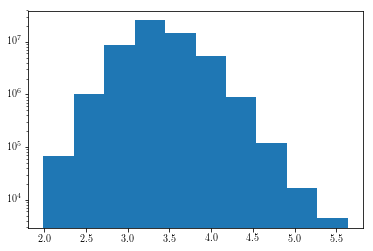

In [217]:
a = sum(pos2[3,corte]*1e10)
print rend1.get_image()
b = np.sum(rend1.get_image())
print b
print shape(rend1.get_image())
areap = (2.*rl/npixel)**2
print areap

dens = rend1.get_image()/areap
print dens
print median(dens)

rend1.set_logscale()
rend1.histogram(log=True)


In [218]:
b*100/a

98.952330101652265

In [2]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import rotation_davidmod as rot_david
import rotation_mio as rot_orne
import numpy as np
import barstrength2 as strng
import time_conversion as tiempo
import sphviewer as sph
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')
vector3 = ('A','B')
carpeta = ('9in1_M31_new/','9in1_MW/')


#path = 'home/ornela/SimCLUES/'
path = '/home/omarioni/'

atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
# aexp = aexp[::-1]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(360,358,-1)
for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    print isnap
    for i in range(0,1):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)

#         print isnap#, time

        #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)

        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

        #----------------------masas----------------------------
        mstr = mstr/h

        r200 = r200*aexp[isnap]/h
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

        #------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]
        r50 = r_sort[cincuenta][-1]             

        #--------------------------------------------         
        veloc,=np.where(r<r50)

        #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        kk, = np.where(r<3*aexp[isnap]) 
        
        jx = sum(mstr[kk] * (ystr[kk]*vz[kk] - zstr[kk]*vy[kk]))
        jy = sum(mstr[kk] * (zstr[kk]*vx[kk] - xstr[kk]*vz[kk]))
        jz = sum(mstr[kk] * (xstr[kk]*vy[kk] - ystr[kk]*vx[kk]))
        
        print 'jx=', jx, 'jy=', jy, 'jz=', jz

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot_david.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])
  
        pos=np.ndarray([3,3])
        pos[0,0]=e1x
        pos[0,1]=e1y
        pos[0,2]=e1z
        
        pos[1,0]=e2x
        pos[1,1]=e2y
        pos[1,2]=e2z
        
        pos[2,0]=e3x
        pos[2,1]=e3y
        pos[2,2]=e3z
        
        print '----------rotacion david-------'
        print pos
        

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot_orne.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])
  
        pos=np.ndarray([3,3])
        pos[0,0]=e1x
        pos[0,1]=e1y
        pos[0,2]=e1z
        
        pos[1,0]=e2x
        pos[1,1]=e2y
        pos[1,2]=e2z
        
        pos[2,0]=e3x
        pos[2,1]=e3y
        pos[2,2]=e3z
        
        print '----------rotacion ornela-------'
        print pos
        
        

360
jx= 29.7719 jy= -20.201 jz= 0.811321
----------rotacion david-------
[[-0.56147441 -0.8274941   0.        ]
 [ 0.01865544 -0.01265816 -0.99974584]
 [ 0.82728378 -0.56133171  0.0225445 ]]
----------rotacion ornela-------
[[-0.56147441 -0.8274941   0.        ]
 [ 0.01865544 -0.01265816 -0.99974584]
 [ 0.82728378 -0.56133171  0.0225445 ]]
359
jx= 29.4319 jy= -19.4285 jz= -0.0334033
----------rotacion david-------
[[ -5.50909587e-01  -8.34564933e-01   0.00000000e+00]
 [ -7.90483114e-04   5.21810477e-04  -9.99999551e-01]
 [  8.34564558e-01  -5.50909340e-01  -9.47179881e-04]]
----------rotacion ornela-------
[[ -5.50909587e-01  -8.34564933e-01   0.00000000e+00]
 [ -7.90483114e-04   5.21810477e-04  -9.99999551e-01]
 [  8.34564558e-01  -5.50909340e-01  -9.47179881e-04]]


## Galaxias de GASOLINE

1024


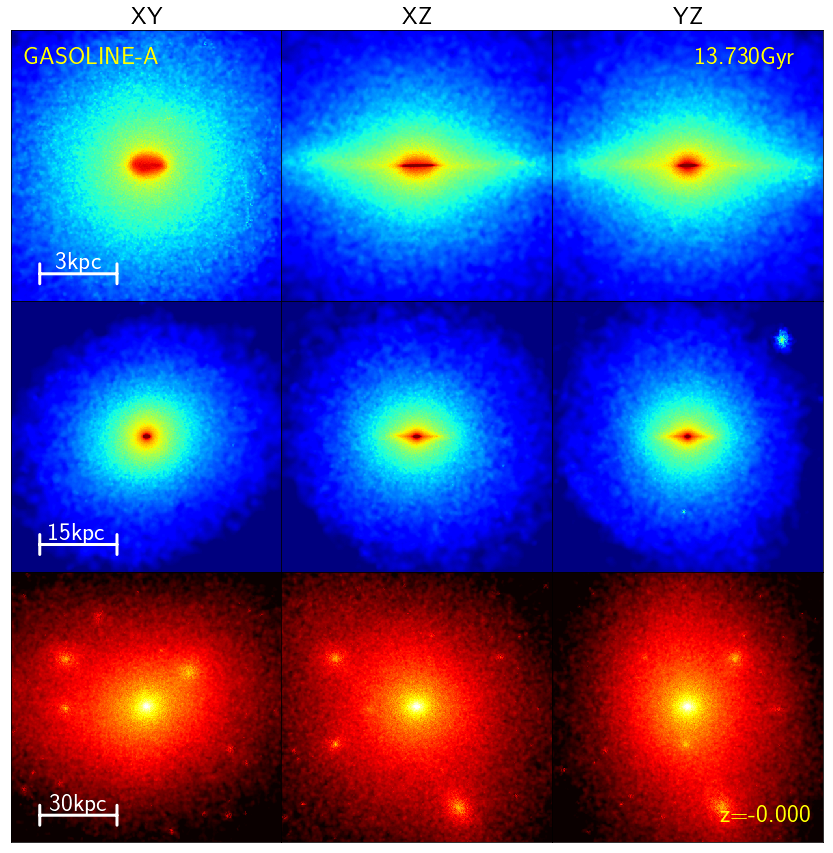

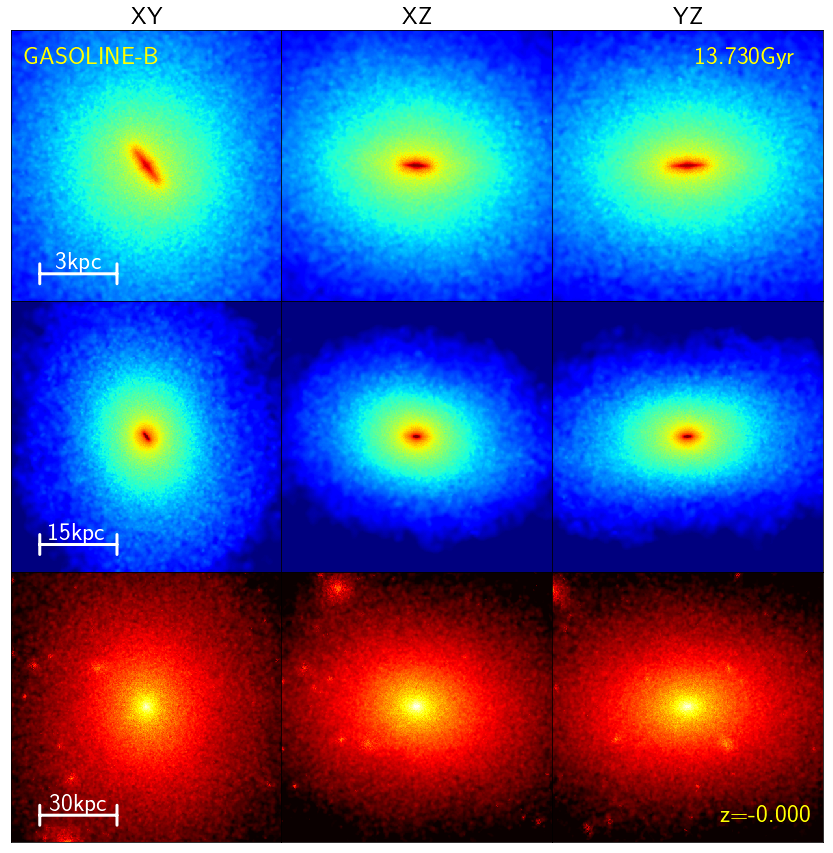

In [6]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import barstrength2 as strng
import time_conversion as tiempo
import sphviewer as sph
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

a0 = 1.
vector = (1,2,4)
vector2 = ('M31', 'MW')
vector3 = ('A','B')
carpeta = ('9in1_M31/', '9in1_MW/')

#path = 'home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,len(snapshot)-2,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    print snapshot[j]

    for i in range(0,2):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value

        pstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pdrk = snap['subhalo_00' + str('%s' %vector[i]) + '/Drk/Coordinates'].value
        mdrk = snap['subhalo_00' + str('%s' %vector[i]) + '/Drk/Masses'].value

        z = a0/aexp - 1.
        #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = pstr[:,0]-cm[0]
        ystr = pstr[:,1]-cm[1]
        zstr = pstr[:,2]-cm[2]
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xdrk = pdrk[:,0]-cm[0]
        ydrk = pdrk[:,1]-cm[1]
        zdrk = pdrk[:,2]-cm[2]
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

        v_x = vel[:,0] 
        v_y = vel[:,1] 
        v_z = vel[:,2] 

        #----------------------masas----------------------------

        r200 = r200*aexp
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

        #------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]
        r50 = r_sort[cincuenta][-1]             

        #--------------------------------------------         
        veloc,=np.where(r<r50)

        #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

        ##posiciones de partículas que se quiere graficar
        ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        xn_drk = e1x*xdrk + e1y*ydrk + e1z*zdrk
        yn_drk = e2x*xdrk + e2y*ydrk + e2z*zdrk
        zn_drk = e3x*xdrk + e3y*ydrk + e3z*zdrk

        
        pos=np.ndarray([4,np.size(xn)])
        pos[0,:]=xn
        pos[1,:]=yn
        pos[2,:]=zn
        pos[3,:]=mstr
        
        pos2=np.ndarray([4,np.size(xn_drk)])
        pos2[0,:]=xn_drk
        pos2[1,:]=yn_drk
        pos2[2,:]=zn_drk
        pos2[3,:]=mdrk
        
        fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))#sharex=True, sharey=True) #, sharex=True,
#                                gridspec_kw = {'height_ratios':[2,5]})
        fig.subplots_adjust(bottom=0.01, left =0.03, right = 0.97, top = 0.95, wspace=0.0, hspace= 0.0)

#----------------------------------------------------------------------
#---------------------generador del gráfico1-----------------
        rl= 6   
        corte,=np.where((xn <rl) & (yn <rl) & (zn <rl) & (xn >-rl) & (yn >-rl) & (zn >-rl))


        #-----rango que tiene la escala  de colores-----
        vmin=3
        vmax=7

        # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='jet'

        nb1 = 5
#         nb1 = 100 

        particles=sph.Particles(pos[:3,corte],mstr[corte],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax[0,0].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[0,0].set_xlim(-5,5)
        ax[0,0].set_ylim(-5,5)
        ax[0,0].set_xticks([])
        ax[0,0].set_yticks([])
        ax[0,0].set_yticklabels([])
        ax[0,0].set_xticklabels([])
#         ax[0,0].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,0].minorticks_on()
#         ax[0,0].tick_params( labelsize=40)
#         ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
        ax[0,0].text(-4.5, 4,'GASOLINE-'+str('%s'%vector3[i]), fontsize=25, color='yellow', ha='left', va='center') 
        # ax[1,0].plot(0,0,'k+', markersize=20, color='k')
        ax[0,0].set_title('XY', loc='center', fontsize=25)
        ax[0,0].annotate("",xy=(-4, -4), xycoords='data',xytext=(-1, -4),textcoords='data',
                     ha='center', va='center', 
                    arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=3))

        ax[0,0].text(-2.5, -4, '3kpc', fontsize=25, color='white', ha='center', va='bottom')


#--------------------------------------
        particles=sph.Particles(pos[:3,corte],mstr[corte],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax[0,0]=fig.add_subplot(221)
        ax[0,1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[0,1].set_xlim(-5,5)
        ax[0,1].set_ylim(-5,5)
        ax[0,1].set_xticks([])
        ax[0,1].set_yticks([])
        ax[0,1].set_xticklabels([])
        ax[0,1].set_yticklabels([])
#         ax[0,2].set_ylabel('$z\:[kpc]$', fontsize=40)
#         ax[0,2].set_xlabel('$x\:[kpc]$', fontsize=40)
#         ax[0,1].minorticks_on()
#         ax[0,1].tick_params( labelsize=40)
#         ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[1,0].text(4.3, 4.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[1,0].text(-4.3, 4.3,'Face-on', fontsize=30, color='yellow', ha='left', va='center') 
        ax[0,1].set_title('XZ', loc='center', fontsize=25)

#--------------------------------------
        particles=sph.Particles(pos[:3,corte],mstr[corte],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], p=90, t=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax=fig.add_subplot(222)
        ax[0,2].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[0,2].set_xlim(-5,5)
        ax[0,2].set_ylim(-5,5)
        ax[0,2].set_xticks([])
        ax[0,2].set_yticks([])
        ax[0,2].set_xticklabels([])
        ax[0,2].set_yticklabels([])
#         ax[0,1].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,1].set_xlabel('$z\:[kpc]$', fontsize=40)
#         ax[0,2].minorticks_on()
#         ax[0,2].tick_params( labelsize=40)
#         ax[0,2].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[0,2].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
        ax[0,2].set_title('YZ', loc='center', fontsize=25)
        ax[0,2].text(4, 4,str('%.3f'%time)+'Gyr', fontsize=25, color='yellow', ha='right', va='center') 
#         ax[0,1].text(-4.3, 1.3,'Edge-on', fontsize=30, color='yellow', ha='left', va='center') 


    
#--------------------------------------------------------------------------------------------------------
#---------------------generador del gráfico2-----------------
        rl= 30   
        corte,=np.where((xn <rl) & (yn <rl) & (zn <rl) & (xn >-rl) & (yn >-rl) & (zn >-rl))


        #-----rango que tiene la escala  de colores-----
        vmin=3
        vmax=7.5

        # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='jet'

#         nb1 = 100 

        particles=sph.Particles(pos[:3,corte],mstr[corte],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax[1,0].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,0].set_xlim(-25,25)
        ax[1,0].set_ylim(-25,25)
        ax[1,0].set_xticks([])
        ax[1,0].set_yticks([])
        ax[1,0].set_yticklabels([])
        ax[1,0].set_xticklabels([])
#         ax[0,0].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,0].minorticks_on()
#         ax[0,0].tick_params( labelsize=40)
#         ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[0,0].text(4.3, 1.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
        # ax[1,0].plot(0,0,'k+', markersize=20, color='k')
#         ax[0,0].set_title('GADGET - A', loc='center', fontsize=30)
        ax[1,0].annotate("",xy=(-20, -20), xycoords='data',xytext=(-5, -20),textcoords='data',
                     ha='center', va='center', 
                    arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=3))

        ax[1,0].text(-12.5, -20, '15kpc', fontsize=25, color='white', ha='center', va='bottom')


#--------------------------------------
        particles=sph.Particles(pos[:3,corte],mstr[corte],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax=fig.add_subplot(222)
        ax[1,1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,1].set_xlim(-25,25)
        ax[1,1].set_ylim(-25,25)
        ax[1,1].set_xticks([])
        ax[1,1].set_yticks([])
        ax[1,1].set_xticklabels([])
        ax[1,1].set_yticklabels([])
#         ax[0,1].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,1].set_xlabel('$z\:[kpc]$', fontsize=40)
#         ax[1,1].minorticks_on()
#         ax[1,1].tick_params( labelsize=40)
#         ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[0,1].set_title('time ='+str('%2.3f' %time)+'Gyr', loc='center', fontsize=30)
#         ax[0,1].text(4.3, 1.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[0,1].text(-4.3, 1.3,'Edge-on', fontsize=30, color='yellow', ha='left', va='center') 

#--------------------------------------
        particles=sph.Particles(pos[:3,corte],mstr[corte],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], p=90,t=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax[0,0]=fig.add_subplot(221)
        ax[1,2].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,2].set_xlim(-25,25)
        ax[1,2].set_ylim(-25,25)
        ax[1,2].set_xticks([])
        ax[1,2].set_yticks([])
        ax[1,2].set_xticklabels([])
        ax[1,2].set_yticklabels([])
#         ax[0,2].set_ylabel('$z\:[kpc]$', fontsize=40)
#         ax[0,2].set_xlabel('$x\:[kpc]$', fontsize=40)
#         ax[1,2].minorticks_on()
#         ax[1,2].tick_params( labelsize=40)
#         ax[1,2].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[1,2].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[1,0].text(4.3, 4.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[1,0].text(-4.3, 4.3,'Face-on', fontsize=30, color='yellow', ha='left', va='center') 
        # ax[1,0].set_title('GADGET', loc='center', fontsize=30)
    
#--------------------------------------------------------------------------------------------------------
#---------------------generador del gráfico3-----------------
        rl= 60   
        corte,=np.where((xn_drk <rl) & (yn_drk <rl) & (zn_drk <rl) & (xn_drk >-rl) & (yn_drk >-rl) & (zn_drk >-rl))


        #-----rango que tiene la escala  de colores-----
        vmin=5.5
        vmax=7.5

        # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='hot'

#         nb1 = 300 

        particles=sph.Particles(pos2[:3,corte],mdrk[corte],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax[2,0].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[2,0].set_xlim(-50,50)
        ax[2,0].set_ylim(-50,50)
        ax[2,0].set_xticks([])
        ax[2,0].set_yticks([])
        ax[2,0].set_xticklabels([])
        ax[2,0].set_yticklabels([])
#         ax[0,0].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[2,0].minorticks_on()
#         ax[2,0].tick_params( labelsize=40)
#         ax[2,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[2,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[0,0].text(4.3, 1.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
        # ax[1,0].plot(0,0,'k+', markersize=20, color='k')
#         ax[0,0].set_title('GADGET - A', loc='center', fontsize=30)
        ax[2,0].annotate("",xy=(-40, -40), xycoords='data',xytext=(-10, -40),textcoords='data',
                     ha='center', va='center', 
                    arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=3))

        ax[2,0].text(-25, -40, '30kpc', fontsize=25, color='white', ha='center', va='bottom')


#--------------------------------------
        particles=sph.Particles(pos2[:3,corte],mdrk[corte],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax=fig.add_subplot(222)
        ax[2,1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[2,1].set_xlim(-50,50)
        ax[2,1].set_ylim(-50,50)
        ax[2,1].set_xticks([])
        ax[2,1].set_yticks([])
        ax[2,1].set_xticklabels([])
        ax[2,1].set_yticklabels([])
#         ax[0,1].set_ylabel('$y\:[kpc]$', fontsize=40)
#         ax[0,1].set_xlabel('$z\:[kpc]$', fontsize=40)
#         ax[2,1].minorticks_on()
#         ax[2,1].tick_params( labelsize=40)
#         ax[2,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[2,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[0,1].set_title('time ='+str('%2.3f' %time)+'Gyr', loc='center', fontsize=30)
#         ax[0,1].text(4.3, 1.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[0,1].text(-4.3, 1.3,'Edge-on', fontsize=30, color='yellow', ha='left', va='center') 

#--------------------------------------
        particles=sph.Particles(pos2[:3,corte],mdrk[corte],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], p=90, t=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax[0,0]=fig.add_subplot(221)
        ax[2,2].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[2,2].set_xlim(-50,50)
        ax[2,2].set_ylim(-50,50)
        ax[2,2].set_xticks([])
        ax[2,2].set_yticks([])
        ax[2,2].set_xticklabels([])
        ax[2,2].set_yticklabels([])
#         ax[0,2].set_ylabel('$z\:[kpc]$', fontsize=40)
#         ax[0,2].set_xlabel('$x\:[kpc]$', fontsize=40)
#         ax[2,2].minorticks_on()
#         ax[2,2].tick_params( labelsize=40)
#         ax[2,2].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax[2,2].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
#         ax[1,0].text(4.3, 4.3,'A', fontsize=30, color='yellow', ha='center', va='center') 
#         ax[1,0].text(-4.3, 4.3,'Face-on', fontsize=30, color='yellow', ha='left', va='center') 
        # ax[1,0].set_title('GADGET', loc='center', fontsize=30)
        ax[2,2].text(45, -40,'z='+str('%.3f'%z), fontsize=25, color='yellow', ha='right', va='center') 
        
#         path2 = '/home/omarioni/Barras_GdGs/Barras_Gs/_imagenes/snapshotsGS/'
#         fig.savefig(path2 + str('%s'%carpeta[i]) + str('%s' %vector2[i])+'_'+str('%s' %snapshot[j])+'.png',
#                     dpi = 100, xxbox_inches='tight')
        plt.show()
        plt.close()